<a href="https://colab.research.google.com/github/anindabitm/Open-Cities-AI-Challenge-Segmenting-Buildings-for-Disaster-Resilience/blob/master/Open_cities_challenge_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks to John Whitaker for the starter code and Qubvel for the segmentation model library

In [0]:
# Install required libs
!pip install -U segmentation-models-pytorch 
import os
os._exit(0)

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=060a034016ef85f34b1d3a3540101f38390d9ce71d16b4072a715d166a9f4463
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=0b36c4861c646b435e7532c5f0e9d1905fdf369ccaa87d616a379dc032af4a56
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [0]:
#!pip uninstall -y segmentation-models-pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading data

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pickle
import os
import glob
import pandas as pd
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
path='/content/drive/My Drive/open_cities_ai'
ims = glob.glob(path+'/images-256/*.png')
df = pd.DataFrame({
    'img_path':ims,
    'mask_path':[im.replace('images', 'masks').replace('.png', '_mask.png') for im in ims],
    'valid':False
})
# Add some useful columns
#print(df.loc[1]['img_path'])
df['scene_id'] = df['img_path'].apply(lambda x: x.split("_")[3])
df['area'] = df['img_path'].apply(lambda x: x.split("_")[2].split("/")[-1])
# View
print(df.shape)
df.head()

(584, 5)


,img_path,mask_path,valid,scene_id,area
0,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
1,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
2,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
3,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
4,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc


In [0]:
x_train_df = df.loc[df['area']=='acc']['img_path']
y_train_df = df.loc[df['area']=='acc']['mask_path']

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [0]:
class Dataset(BaseDataset):
    def __init__(
            self, 
            images_fn, 
            masks_fn, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fn = images_fn
        self.masks_fn = masks_fn
        # convert str names to class values on masks
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fn[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.asarray(Image.open(self.masks_fn[i])).astype(np.float32)
        mask=np.expand_dims(mask,axis=-1)        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fn)

class Test_Dataset(BaseDataset):
    
      
    def __init__(
            self, 
            images_fn, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fn = images_fn
        self.augmentation=augmentation
        self.preprocessing=preprocessing
           
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fn[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        dim = (256,256)
        # resize image
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        return image
        
    def __len__(self):
        return len(self.images_fn)


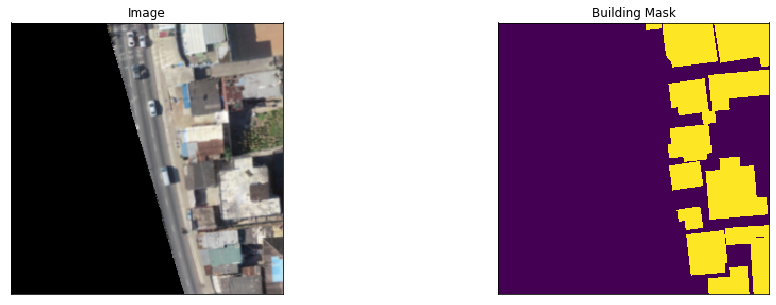

In [31]:
# Lets look at data we have

dataset = Dataset(x_train_df, y_train_df)

image, mask = dataset[5] # get some sample

visualize(
    image=image, 
    building_mask=mask.squeeze(axis=-1)
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [8]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-kc_rayby
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-kc_rayby
     |████████████████████████████████| 634kB 7.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=73e9d0c51e98c2238f661e091aa25a6cb854d18d6acdc6c1aaf0b1167dc6cd42
  Stored in directory: /tmp/pip-ephem-wheel-cache-oay9c54s/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=1882f7ab712e74355ba080670fb3b4df93099080433af3a980271de1ceec5497
  Stored in directory: /tmp/pip-ephem-wheel-cache-oay9c54s/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [0]:
import albumentations as albu

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        albu.RandomCrop(height=256, width=256, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        albu.Lambda(mask=round_clip_0_1)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256),
        albu.Lambda(mask=round_clip_0_1)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

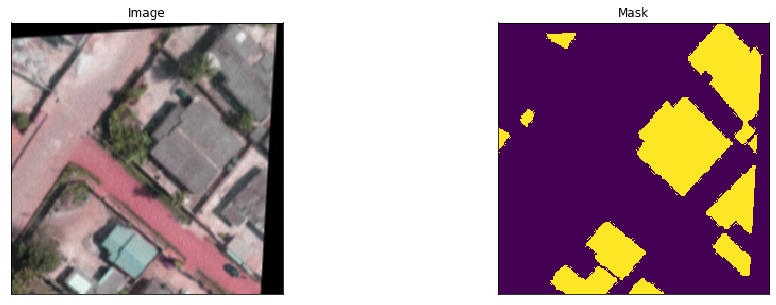

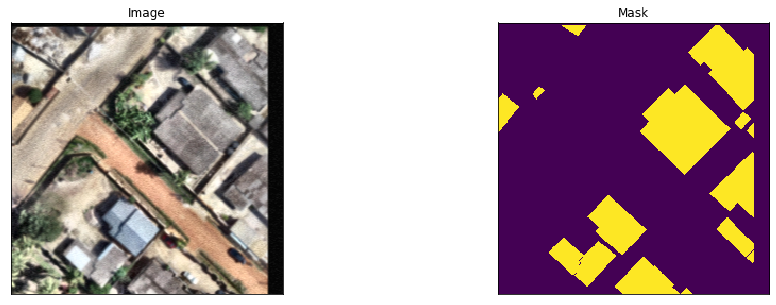

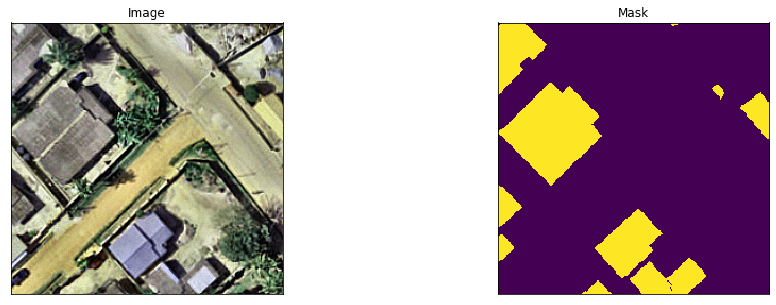

In [32]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_df, 
    y_train_df, 
    augmentation=get_training_augmentation(), 
   
)


# same image with different random transforms
for i in range(3):
  image,mask=augmented_dataset[1]
  visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
n_classes=1
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION,
  
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
if torch.cuda.is_available():
    model.cuda()

In [0]:
x_valid_df = df.loc[df['area']!='acc']['img_path'].reset_index()['img_path']
y_valid_df = df.loc[df['area']!='acc']['mask_path'].reset_index()['mask_path']

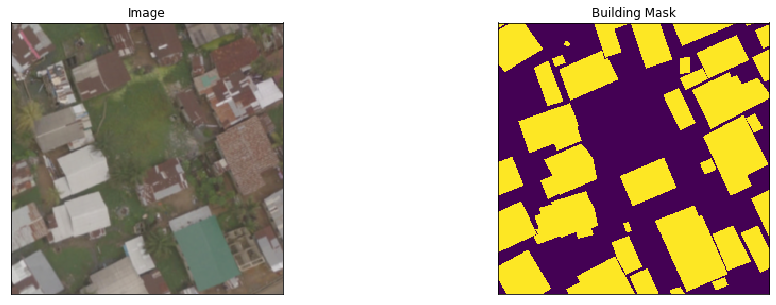

In [34]:
valid_dataset = Dataset(x_valid_df, y_valid_df, augmentation=get_validation_augmentation())
image, mask = valid_dataset[12] # get some sample
visualize(
    image=image, 
    building_mask=mask.squeeze(axis=-1)
)

In [0]:
train_dataset = Dataset(
    x_train_df, 
    y_train_df, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

valid_dataset = Dataset(
    x_valid_df, 
    y_valid_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [0]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [0]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [55]:
# train model for 20 epochs

max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/My Drive/open_cities_ai/pytorch/best_unet_model.pth')
        print('Model saved!')
        
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 143/143 [00:37<00:00,  3.84it/s, dice_loss - 0.3875, iou_score - 0.5086]
Model saved!

Epoch: 1
valid: 100%|██████████| 143/143 [00:05<00:00, 25.68it/s, dice_loss - 0.2935, iou_score - 0.604]
Model saved!

Epoch: 2
valid: 100%|██████████| 143/143 [00:05<00:00, 25.55it/s, dice_loss - 0.2848, iou_score - 0.6221]
Model saved!

Epoch: 3
valid: 100%|██████████| 143/143 [00:05<00:00, 25.46it/s, dice_loss - 0.2542, iou_score - 0.6509]
Model saved!

Epoch: 4
valid: 100%|██████████| 143/143 [00:05<00:00, 26.79it/s, dice_loss - 0.2378, iou_score - 0.6581]
Model saved!

Epoch: 5
valid: 100%|██████████| 143/143 [00:05<00:00, 29.09it/s, dice_loss - 0.2566, iou_score - 0.6403]

Epoch: 6
valid: 100%|██████████| 143/143 [00:05<00:00, 25.60it/s, dice_loss - 0.2426, iou_score - 0.6556]

Epoch: 7
valid: 100%|██████████| 143/143 [00:05<00:00, 25.84it/s, dice_loss - 0.2316, iou_score - 0.6659]
Model saved!

Epoch: 8
valid: 100%|██████████| 143/143 [00:05<00:00, 25.88it/s, 

## Test best saved model

In [0]:
# load best saved checkpoint
best_model = torch.load('/content/drive/My Drive/open_cities_ai/pytorch/best_unet_model.pth')

In [16]:
x_test_df=pd.read_csv('/content/drive/My Drive/open_cities_ai/test/test.csv')
x_test_df.head()

,Unnamed: 0,fn,id
0,0,/content/drive/My Drive/open_cities_ai/test/e9...,e93a2d
1,1,/content/drive/My Drive/open_cities_ai/test/e9...,e959dc
2,2,/content/drive/My Drive/open_cities_ai/test/e9...,e91b9c
3,3,/content/drive/My Drive/open_cities_ai/test/e9...,e94422
4,4,/content/drive/My Drive/open_cities_ai/test/e9...,e98330


In [39]:
x_test_df.shape

(11481, 3)

(256, 256, 3)


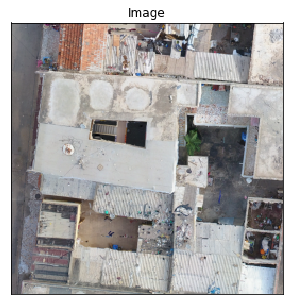

In [40]:
# create test dataset
test_dataset_vis = Test_Dataset(x_test_df['fn'])
image_vis = test_dataset_vis[105] # get some sample
print(image_vis.shape)
visualize(
    image=image_vis
    )


In [0]:
test_dataset = Test_Dataset(x_test_df['fn'],preprocessing=get_preprocessing(preprocessing_fn))
test_dataloader=DataLoader(test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1024, 1024)


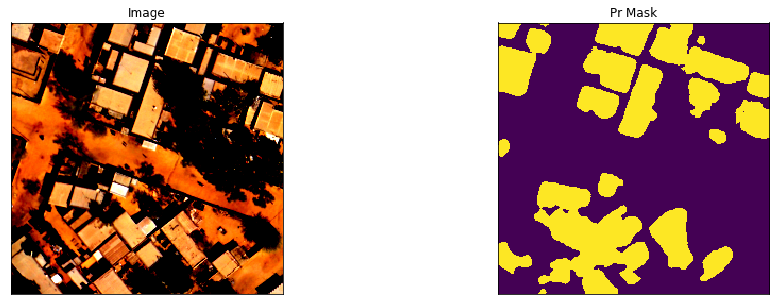

In [52]:
image = test_dataset[15]   
#print('Shapes:',image.transpose(1,2,0).shape,'---',mask.transpose(1,2,0).squeeze(axis=-1).shape)
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#print(x_tensor.shape)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
pred_im = Image.fromarray(pr_mask.astype(np.uint8))
scaled_im = pred_im.resize((1024, 1024), Image.NEAREST)
print(np.array(scaled_im).shape)
#plt.imshow(pr_mask)
#plt.imshow(scaled_im)
#plt.show()
#print(pr_mask.shape)
visualize(image=image.transpose(1,2,0),pr_mask=pr_mask)

## Visualize predictions

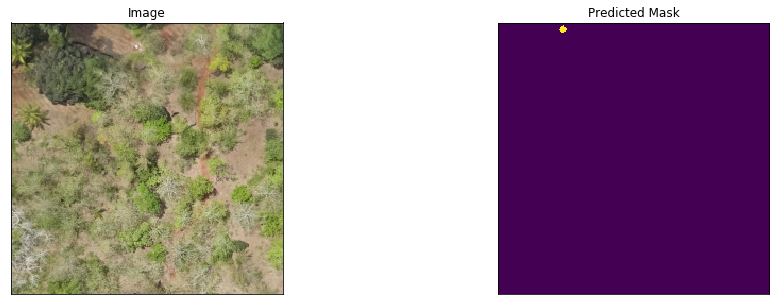

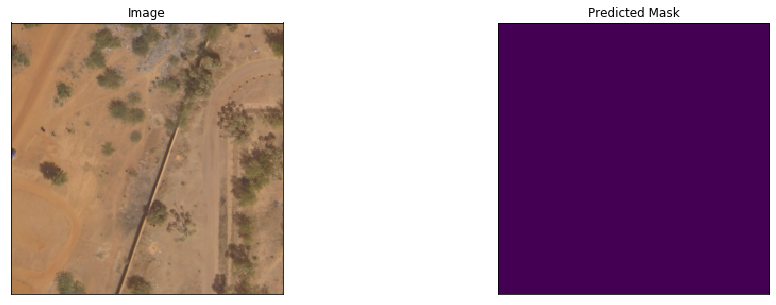

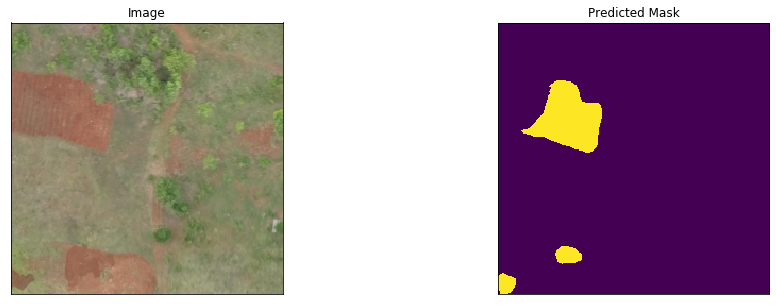

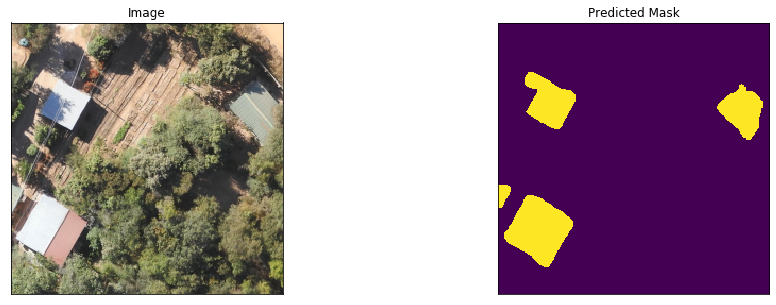

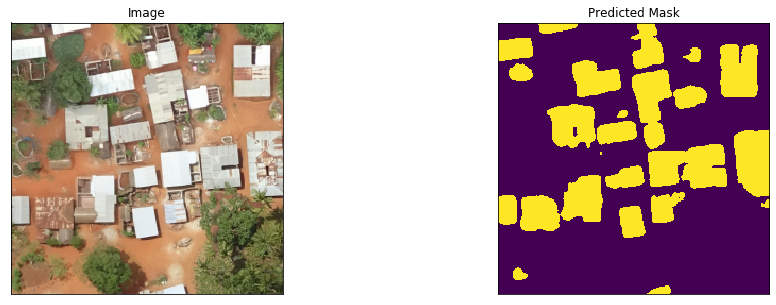

In [53]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n].astype('uint8')
    image = test_dataset[n]   
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pred_im = Image.fromarray(pr_mask.astype(np.uint8))
    scaled_im = pred_im.resize((1024, 1024), Image.NEAREST)
    #print('Shape of mask',pr_mask.shape)
    visualize(
        image=image_vis, 
        predicted_mask=scaled_im
    )

In [0]:
#!rm -rf '/content/drive/My Drive/open_cities_ai/submission2'
!mkdir '/content/drive/My Drive/open_cities_ai/submission3'

In [0]:
from tqdm import tqdm

for i in tqdm(range(len(x_test_df))):
  im_id = x_test_df['id'].values[i]
  img = test_dataset[i]   
  x_tensor = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
  mask = best_model.predict(x_tensor)
  mask = (mask.squeeze().cpu().numpy().round()) 
  #pred_arr = mask.squeeze(axis=0).squeeze(axis=-1)
  pred_im = Image.fromarray(mask.astype(np.uint8))
  scaled_im = pred_im.resize((1024, 1024), Image.NEAREST)
  scaled_im.save('/content/drive/My Drive/open_cities_ai/submission3/'+str(im_id)+'.TIF', compression='tiff_deflate')

Streaming output truncated to the last 5000 lines.
100%|██████████| 11481/11481 [1:18:22<00:00,  1.89it/s]


In [0]:
import os
for i in range(len(x_test_df)):
  im_id = x_test_df['id'].values[i]
  if not os.path.isfile('/content/drive/My Drive/open_cities_ai/submission2/'+str(im_id)+'.TIF'):
    print(im_id)

In [0]:
!cd '/content/drive/My Drive/open_cities_ai/submission2'; zip -q -r submission.zip *.TIF # Add to archive

@misc{Yakubovskiy:2019,
  Author = {Pavel Yakubovskiy},
  Title = {Segmentation Models Pytorch},
  Year = {2020},
  Publisher = {GitHub},
  Journal = {GitHub repository},
  Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
}